In [129]:
!pip install textcleaner

In [385]:
import numpy as np
import pickle
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import sklearn as sk
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import statistics
from sklearn.linear_model import Lasso

import textcleaner as tc 
from sklearn.neighbors import KNeighborsRegressor
import re
import nltk
from sklearn.svm import SVR
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.compose import ColumnTransformer
import matplotlib
from matplotlib import pylab as plt
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import warnings
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
warnings.filterwarnings("ignore")

from os.path import dirname, abspath
d = dirname(dirname(abspath("data1030-student-f19/Whiskey1030/")))
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [152]:
#load data
dfmodel = pd.read_csv(dirname(d)+'/Data/dfmodel_nvars.csv')
wordvar = pd.read_csv(dirname(d)+'/Data/ddclean.csv')
names50 = pd.read_csv(dirname(d)+'/Data/names50.csv')
names = pd.read_csv(dirname(d)+"/Data/names.csv")

In [153]:
dfmodel['log_price'] = np.log(dfmodel['Wprice'])
dfmodel.head()

name  \
0                   johnnie walker blue label, 40%   
1  black bowmore, 1964 vintage, 42 year old, 40.5%   
2        bowmore 46 year old distilled 1964, 42.9%   
3                   compass box the general, 53.4%   
4                          chivas regal ultis, 40%   

                     category  review.point   Wprice  \
0       Blended Scotch Whisky            97    225.0   
1          Single Malt Scotch            97   4500.0   
2          Single Malt Scotch            97  13500.0   
3  Blended Malt Scotch Whisky            96    325.0   
4  Blended Malt Scotch Whisky            96    160.0   

                                         description  percent  d_len  n_len  \
0  magnificently powerful and intense caramels dr...     40.0   67.0    5.0   
1  what impresses me most is how this whisky evol...     40.5   83.0    9.0   
2  there have been some legendary bowmores from t...     42.9   86.0    8.0   
3  with a name inspired by a 1926 buster keaton m...     53.4   79.0    6.0   
4  captivating enticing and wonderfully charming ...     40.0   73.0    4.0   

    d_charw   n_charw  log_price  
0  6.537313  6.000000   5.416100  
1  5.674699  5.222222   8.411833  
2  5.593023  5.125000   9.510445  
3  5.367089  5.000000   5.783825  
4  6.849315  5.750000   5.075174

In [154]:
dfmodel.describe()

review.point         Wprice      percent        d_len        n_len  \
count   2247.000000    2247.000000  2247.000000  2247.000000  2247.000000   
mean      86.700045     709.205607    47.976987    72.519804     7.756564   
std        4.054055    5660.577607     6.248908    21.882415     3.043309   
min       63.000000      12.000000    40.000000     2.000000     1.000000   
25%       84.000000      70.000000    43.000000    62.000000     5.000000   
50%       87.000000     110.000000    46.000000    72.000000     7.000000   
75%       90.000000     200.000000    52.100000    80.000000    10.000000   
max       97.000000  157000.000000   100.000000   233.000000    19.000000   

           d_charw      n_charw    log_price  
count  2247.000000  2247.000000  2247.000000  
mean      5.865825     5.753762     4.953735  
std       0.331304     0.866010     1.158712  
min       4.592105     3.250000     2.484907  
25%       5.650000     5.166667     4.248495  
50%       5.850000     5.666667     4.700480  
75%       6.067682     6.222222     5.298317  
max       9.000000    10.000000    11.964001

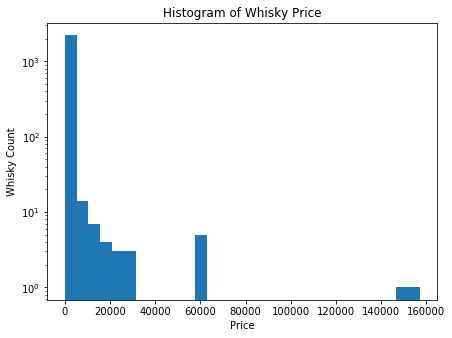

In [155]:
# HISTOGRAM DESCRIPTION LENGTH
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['Wprice'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Price')
plt.ylabel('Whisky Count')
plt.title('Histogram of Whisky Price')
plt.tight_layout()

# show the figure in the notebook or save it as a file
#plt.savefig(dirname(d)+'/Figures/desc_len_hist.png',dpi=300)
plt.show()

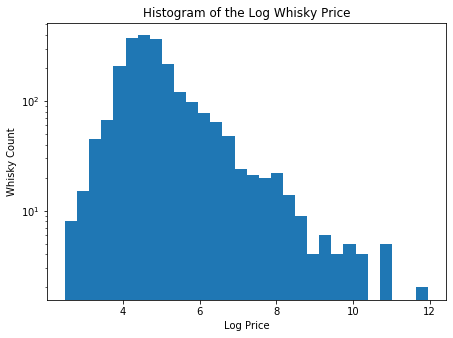

In [156]:
# HISTOGRAM DESCRIPTION LENGTH
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['log_price'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Log Price')
plt.ylabel('Whisky Count')
plt.title('Histogram of the Log Whisky Price')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/logprice_hist.png',dpi=300)
plt.show()

In [157]:
dfmodel['review.point'].describe()

count    2247.000000
mean       86.700045
std         4.054055
min        63.000000
25%        84.000000
50%        87.000000
75%        90.000000
max        97.000000
Name: review.point, dtype: float64

In [158]:
##### convert review score into categorical bins
#bins =[(0, 79), (80, 84), (85, 89),(90,94),(95,100)]
dfmodel['reviewbin'] = pd.cut(x=dfmodel['review.point'], bins=[0, 79, 84, 89, 94,100], labels=["quite poor","poor fair","good fair","good","excelent"])
dfmodel.drop(columns=["Wprice","description",'name'],inplace=True)
dfmodel['review2'] = dfmodel['review.point']**2
dfmodel.head()

category  review.point  percent  d_len  n_len   d_charw  \
0       Blended Scotch Whisky            97     40.0   67.0    5.0  6.537313   
1          Single Malt Scotch            97     40.5   83.0    9.0  5.674699   
2          Single Malt Scotch            97     42.9   86.0    8.0  5.593023   
3  Blended Malt Scotch Whisky            96     53.4   79.0    6.0  5.367089   
4  Blended Malt Scotch Whisky            96     40.0   73.0    4.0  6.849315   

    n_charw  log_price reviewbin  review2  
0  6.000000   5.416100  excelent     9409  
1  5.222222   8.411833  excelent     9409  
2  5.125000   9.510445  excelent     9409  
3  5.000000   5.783825  excelent     9216  
4  5.750000   5.075174  excelent     9216

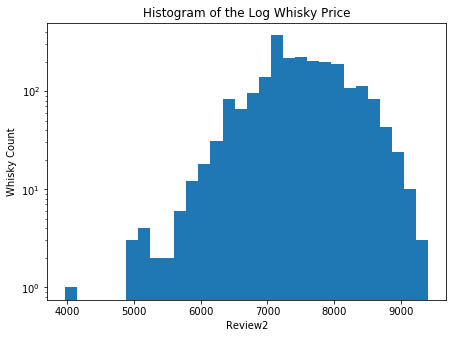

In [159]:
# HISTOGRAM DESCRIPTION LENGTH
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['review2'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Review2')
plt.ylabel('Whisky Count')
plt.title('Histogram of the Log Whisky Price')
plt.tight_layout()
# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/hist_review2.png',dpi=300)
plt.show()

<Figure size 748.8x489.6 with 0 Axes>

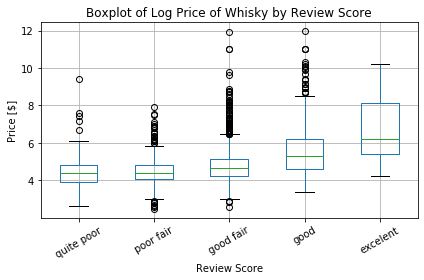

In [160]:
plt.figure(figsize=(10.4,6.8))
dfmodel[['log_price','reviewbin']].boxplot(by='reviewbin')
plt.suptitle('')
plt.title('Boxplot of Log Price of Whisky by Review Score')
plt.ylabel('Price [$]')
plt.xlabel('Review Score')
#plt.ylim(0,800)
plt.xticks(rotation= 30)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/price_reveiwscore_boxplot.png',dpi=900)
plt.show()

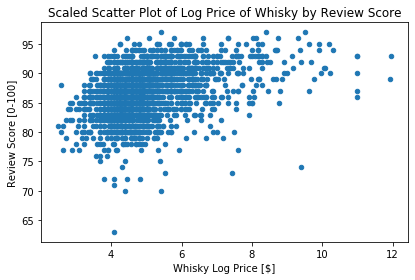

In [161]:
dfmodel.plot.scatter('log_price','review.point') # the color and size of each point can also be defined

plt.xlabel('Whisky Log Price [$]')
plt.ylabel('Review Score [0-100]')
plt.title('Scaled Scatter Plot of Log Price of Whisky by Review Score')
# plt.xlim(0,6100)
# plt.ylim(60,100)
#plt.tight_layout()
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/log_scatter_review_price.png',dpi=900)
plt.show()

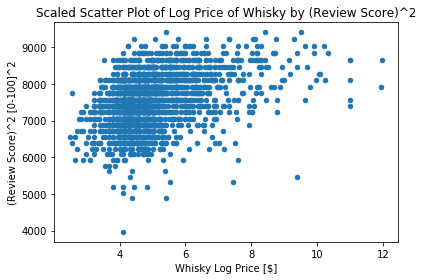

In [162]:
dfmodel.plot.scatter('log_price','review2') # the color and size of each point can also be defined

plt.xlabel('Whisky Log Price [$]')
plt.ylabel('(Review Score)^2 [0-100]^2')
plt.title('Scaled Scatter Plot of Log Price of Whisky by (Review Score)^2')
# plt.xlim(0,6100)
# plt.ylim(60,100)
plt.tight_layout()
plt.tight_layout()
#plt.savefig(dirname(d)+'/Figures/log_scatter_review2_price.png',dpi=900)
plt.show()

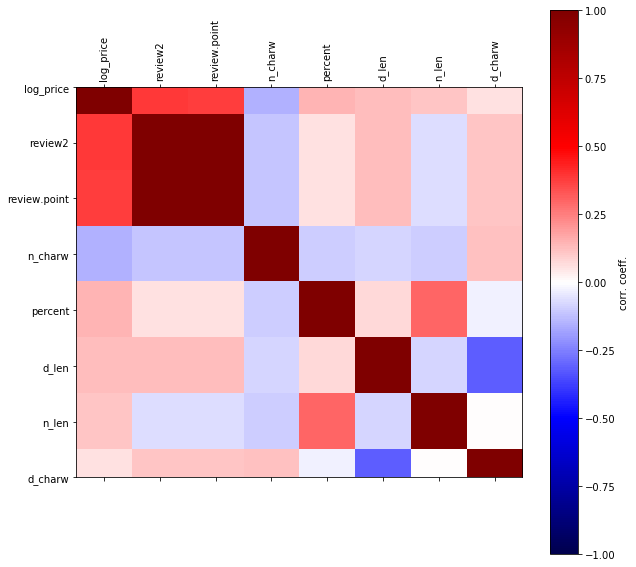

In [163]:
corrmat = dfmodel.corr()

all_cols = np.abs(corrmat).sort_values('log_price',ascending=False)['log_price'].index
cols = all_cols[:10] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.savefig(dirname(d)+'/Figures/log_pricecorrelation.png',dpi=300)
#plt.tight_layout()
plt.show()

In [166]:
def ML_pipeline_kfold_GridSearchCV_lasso(X,y,random_state,n_folds,DF):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    feature_names = f_names

    cat_ftrs = cat_ftr
    num_ftrs = num_ftr
    
    cat_ftrs_i = [DF.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [DF.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)]) 
    
    pipe = make_pipeline(preprocessor, Lasso())
    
    # the parameter(s) we want to tune
    param_grid = {'lasso__alpha': np.logspace(-5,5,num=11)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring=make_scorer(r2_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = num_ftrs #+ \
#                list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, grid.score(X_test, y_test)

In [167]:
# def ML_pipeline_kfold_GridSearchCV_SVR(X,y,random_state,n_folds,DF):
#     # create a test set
#     X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
#     # splitter for _other
#     kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
#     # create the pipeline: preprocessor + supervised ML method
    
#     feature_names = f_names

#     cat_ftrs = cat_ftr
#     num_ftrs = num_ftr
    
#     cat_ftrs_i = [DF.columns.get_loc(x) for x in cat_ftrs]
#     num_ftrs_i = [DF.columns.get_loc(x) for x in num_ftrs]

#     categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
#     numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
#     # collect the transformers
#     preprocessor = ColumnTransformer(
#         transformers=[
#             ('num', numeric_transformer, num_ftrs_i),
#             ('cat', categorical_transformer, cat_ftrs_i)])
        
#     pipe = make_pipeline(preprocessor,SVR(kernel='rbf'))
    
#     # the parameter(s) we want to tune
#     param_grid = {'svr__C': np.logspace(-3,4,num=8),'svr__gamma':  np.logspace(-3,4,num=8)}
#     # prepare gridsearch
#     grid = GridSearchCV(pipe, param_grid=param_grid,scoring=make_scorer(r2_score),
#                         cv=kf, return_train_score = True)
#     # do kfold CV on _other
#     grid.fit(X_other, y_other)
#     return grid, grid.score(X_test, y_test)

In [168]:
def ML_pipeline_kfold_GridSearchCV_RF(X,y,random_state,n_folds,DF):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    feature_names = f_names

    cat_ftrs = cat_ftr
    num_ftrs = num_ftr
    
    cat_ftrs_i = [DF.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [DF.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])
        
    pipe = make_pipeline(preprocessor,RandomForestRegressor(random_state=random_state))
    
    # the parameter(s) we want to tune
    param_grid = {'randomforestregressor__min_samples_split': (5,150,10),'randomforestregressor__max_depth': (20,40,5)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring=make_scorer(r2_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test)

In [169]:
def ML_pipeline_kfold_GridSearchCV_KNN(X,y,random_state,n_folds,DF):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    feature_names = f_names

    cat_ftrs = cat_ftr
    num_ftrs = num_ftr
    
    cat_ftrs_i = [DF.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [DF.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)])
        
    pipe = make_pipeline(preprocessor,KNeighborsRegressor())
    
    # the parameter(s) we want to tune
    param_grid = {'kneighborsregressor__n_neighbors': (5,500,50)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring=make_scorer(r2_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test)

In [262]:
df1=dfmodel[['review.point']]
X1=df1.values
y=dfmodel[['log_price']]
f_names = list(dfmodel.columns)
cat_ftr = []
num_ftr = ['review.point']
df1.head(2)

review.point
0            97
1            97

In [220]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(X1,y,i*333, 5, df1)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1472224068382876
test score: 0.1591791084534938
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.16525318422048854
test score: 0.12709144518355875
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.15132099447367817
test score: 0.19321187225596215
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.17096587457289972
test score: 0.16711642013292216
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1621658972250786
test score: 0.1679844779099604
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.17858901466659588
test score: 0.13351554980473612
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.15889605208379914
test score: 0.19290903712935148
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1866409007169969
test score: 0.03825825021532836
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1684600666682069
test score: 0.1566894901917335
{'kneighborsregressor__n_neighbors'

In [263]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(X1,y,i*333, 5, df1)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
lasso_std=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 0.01}
best CV score: 0.12818323936997003
test score: 0.13790600301729405
{'lasso__alpha': 0.01}
best CV score: 0.14092700522650337
test score: 0.11022569616870381
{'lasso__alpha': 0.01}
best CV score: 0.13508627531055328
test score: 0.13939173288747686
{'lasso__alpha': 0.001}
best CV score: 0.1456610986186611
test score: 0.10616075744727038
{'lasso__alpha': 0.01}
best CV score: 0.13379007451382696
test score: 0.13919919343265652
{'lasso__alpha': 0.001}
best CV score: 0.14251453945871126
test score: 0.1281863415704828
{'lasso__alpha': 0.001}
best CV score: 0.13079000357448842
test score: 0.16796704805678275
{'lasso__alpha': 1e-05}
best CV score: 0.15828354638489622
test score: 0.0595136511745229
{'lasso__alpha': 0.01}
best CV score: 0.14249194550236163
test score: 0.11290206411807613
{'lasso__alpha': 0.01}
best CV score: 0.1520247267025064
test score: 0.0769486445867198
 
BEST 0.16796704805678275
test R2: 0.12 +/- 0.03
mean: 0.1178401132459986
std: 0.030390682778361388


In [217]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(X1,y,i*333, 5, df1)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.1454426582641037
test score: 0.17402617258786746
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16834691046560696
test score: 0.14396589474044552
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.15811938805573972
test score: 0.19134729118124305
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16997713104929357
test score: 0.18394882783661937
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16188570133203245
test score: 0.15953821673606405
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16847872431089495
test score: 0.1596971482393933
{'randomforestregressor__max_depth': 5, 'randomforestregressor__mi

In [259]:
dfbasic=dfmodel[['review.point','review2']]
Xbasic=dfbasic.values
y=dfmodel[['log_price']]
f_names = list(dfbasic.columns)
cat_ftr = []
num_ftr = ['review.point','review2']
dfbasic.head(2)

review.point  review2
0            97     9409
1            97     9409

In [221]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xbasic,y,i*333, 5, dfbasic)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1472224068382876
test score: 0.1591791084534938
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.16525318422048854
test score: 0.12709144518355875
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.15132099447367817
test score: 0.19321187225596215
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.17096587457289972
test score: 0.16711642013292216
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1621658972250786
test score: 0.1679844779099604
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.17858901466659588
test score: 0.13351554980473612
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.15889605208379914
test score: 0.19290903712935148
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1866409007169969
test score: 0.03825825021532836
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1684600666682069
test score: 0.1566894901917335
{'kneighborsregressor__n_neighbors'

In [261]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xbasic,y,i*333, 5, dfbasic)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
lasso_std=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 1e-05}
best CV score: 0.15900469086761498
test score: 0.1940639541166408
{'lasso__alpha': 1e-05}
best CV score: 0.1765586642606731
test score: 0.14580355819650404
{'lasso__alpha': 1e-05}
best CV score: 0.16948537931566549
test score: 0.18063434453223115
{'lasso__alpha': 1e-05}
best CV score: 0.17688456220234064
test score: 0.16271347954431015
{'lasso__alpha': 1e-05}
best CV score: 0.17498910255468303
test score: 0.16425458585347041
{'lasso__alpha': 1e-05}
best CV score: 0.17772648851597594
test score: 0.1676673947295637
{'lasso__alpha': 1e-05}
best CV score: 0.16978111368239576
test score: 0.19700266919239506
{'lasso__alpha': 1e-05}
best CV score: 0.2026185802470873
test score: 0.07516907378131799
{'lasso__alpha': 1e-05}
best CV score: 0.18014613073347238
test score: 0.14795713030786495
{'lasso__alpha': 1e-05}
best CV score: 0.18869388329088363
test score: 0.11596831087942316
 
BEST 0.19700266919239506
test R2: 0.16 +/- 0.04
mean: 0.1551234501133721
std: 0.035047707568

In [177]:
# grid, feature_names, X_test, y_test = ML_pipeline_kfold_LR1(X,y,42,4)
# print('test score:',grid.score(X_test,y_test))
# coefs = grid.best_estimator_[-1].coef_
# sorted_indcs = np.argsort(np.abs(coefs))
# plt.rcParams.update({'font.size': 14})
# plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
# plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
# plt.xlabel('coefficient')
# plt.title('not all scaled')
# plt.tight_layout()
# plt.savefig('figures/LR_coefs_notscaled.png',dpi=300)
# plt.show()


In [260]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xbasic,y,i*333, 5, dfbasic)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.14544265826410374
test score: 0.17402617258786723
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16918695083792834
test score: 0.14396589474044552
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.15811938805573972
test score: 0.19134729118124305
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16997713104929346
test score: 0.18394882783661937
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16188570133203242
test score: 0.15953821673606394
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.16847872431089495
test score: 0.15950386672148797
{'randomforestregressor__max_depth': 5, 'randomforestregressor__

In [255]:
dfbasic_bin=dfmodel[['reviewbin']]
Xbin=dfbasic_bin.values
y=dfmodel[['log_price']]
f_names = list(dfbasic.columns)
cat_ftr = ['reviewbin']
num_ftr = []
dfbasic_bin.head(2)

reviewbin
0  excelent
1  excelent

In [224]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xbin,y,i*333, 5, dfbasic_bin)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1047636505672873
test score: 0.16069333775444272
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.11837889087270385
test score: 0.11035460301644573
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.11162826454085113
test score: 0.13130910430706932
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.13274658124763103
test score: 0.1431358599766157
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.11935127731594758
test score: 0.15384722498601666
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.13005807996274962
test score: 0.13548371955267435
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1087609123319677
test score: 0.15975010319513594
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.14340440520637396
test score: 0.021003275840598468
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.13189549811478296
test score: 0.0979240792809224
{'kneighborsregressor__n_neighb

In [258]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xbin,y,i*333, 5, dfbasic_bin)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
rf_lasso=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 0.001}
best CV score: 0.13078385512274893
test score: 0.18187753305295973
{'lasso__alpha': 0.001}
best CV score: 0.1480259960872385
test score: 0.13957193396321488
{'lasso__alpha': 0.001}
best CV score: 0.14422192692111185
test score: 0.1594994059382694
{'lasso__alpha': 1e-05}
best CV score: 0.15237617033440282
test score: 0.14977892617597854
{'lasso__alpha': 0.0001}
best CV score: 0.14133264294436246
test score: 0.1458325151519958
{'lasso__alpha': 0.001}
best CV score: 0.1498953326857295
test score: 0.1483301587835203
{'lasso__alpha': 1e-05}
best CV score: 0.14321370795953126
test score: 0.1673426417249625
{'lasso__alpha': 0.001}
best CV score: 0.17731263761466315
test score: 0.04426297327554618
{'lasso__alpha': 0.0001}
best CV score: 0.16129290840895685
test score: 0.08941859942349406
{'lasso__alpha': 0.0001}
best CV score: 0.16202178069381626
test score: 0.10129544565432236
 
BEST 0.18187753305295973
test R2: 0.13 +/- 0.04
mean: 0.13272101331442637
std: 0.0371692461

In [256]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xbin,y,i*333, 5, dfbasic_bin)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.13095051447835052
test score: 0.18003256567922143
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.1493845225033866
test score: 0.13540853704836553
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.14240095990567192
test score: 0.1598973718053175
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.15102819175809198
test score: 0.15158879848829576
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.14262904878076155
test score: 0.14601282999404364
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.1494991580397938
test score: 0.14851814915933348
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samp

In [183]:
dfmodel.head()

category  review.point  percent  d_len  n_len   d_charw  \
0       Blended Scotch Whisky            97     40.0   67.0    5.0  6.537313   
1          Single Malt Scotch            97     40.5   83.0    9.0  5.674699   
2          Single Malt Scotch            97     42.9   86.0    8.0  5.593023   
3  Blended Malt Scotch Whisky            96     53.4   79.0    6.0  5.367089   
4  Blended Malt Scotch Whisky            96     40.0   73.0    4.0  6.849315   

    n_charw  log_price reviewbin  review2  
0  6.000000   5.416100  excelent     9409  
1  5.222222   8.411833  excelent     9409  
2  5.125000   9.510445  excelent     9409  
3  5.000000   5.783825  excelent     9216  
4  5.750000   5.075174  excelent     9216

In [253]:
#model with original variables from dataset - review.point + review2
dfog=dfmodel[['review.point','category','review2']]
Xog=dfog.values
y=dfmodel[['log_price']]
f_names = list(dfog.columns)
cat_ftr = ['category']
num_ftr = ['review.point','review2']
dfog.head(2)

review.point               category  review2
0            97  Blended Scotch Whisky     9409
1            97     Single Malt Scotch     9409

In [227]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xog,y,i*333, 5, dfog)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.18911343122612215
test score: 0.2485402140524977
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.22083947646049176
test score: 0.19088278584117502
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.20905276947152282
test score: 0.22390825510680812
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.21351779872453008
test score: 0.22413657972677514
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.20430701021192602
test score: 0.2079263803598551
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.22393831366135925
test score: 0.19648144478018725
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.20760644440371942
test score: 0.2287810404338605
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.23655406101085777
test score: 0.09000843816281279
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.21955725063451417
test score: 0.18490047920515218
{'kneighborsregressor__n_neighb

In [254]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xog,y,i*333, 5, dfog)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
lasso_std=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 1e-05}
best CV score: 0.20249393686085052
test score: 0.2542006095751814
{'lasso__alpha': 1e-05}
best CV score: 0.22434653999941462
test score: 0.18452795725465776
{'lasso__alpha': 1e-05}
best CV score: 0.21661555326729842
test score: 0.21153731393681197
{'lasso__alpha': 1e-05}
best CV score: 0.22182308104032183
test score: 0.20265029088294773
{'lasso__alpha': 1e-05}
best CV score: 0.22192447979702248
test score: 0.20285965097648917
{'lasso__alpha': 1e-05}
best CV score: 0.22085210462958546
test score: 0.22232198479723753
{'lasso__alpha': 1e-05}
best CV score: 0.21710305919087444
test score: 0.23920338825910015
{'lasso__alpha': 1e-05}
best CV score: 0.2452098135088012
test score: 0.1253942489056986
{'lasso__alpha': 1e-05}
best CV score: 0.2274840349259401
test score: 0.18850119134242782
{'lasso__alpha': 1e-05}
best CV score: 0.23489154027850362
test score: 0.14704676838479813
 
BEST 0.2542006095751814
test R2: 0.2 +/- 0.04
mean: 0.19782434043153502
std: 0.0371692461444

In [252]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xog,y,i*333, 5, dfog)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.1920104952776168
test score: 0.23528472906562947
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.20972324726989727
test score: 0.18887879567047217
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.19892876477586685
test score: 0.229589902109692
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.21506266351923153
test score: 0.24138512642843335
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.2082421760676208
test score: 0.22530531066502069
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 150}
best CV score: 0.20962845110227785
test score: 0.19609131869679575
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samp

In [61]:
dfmodel.head()

category  review.point  percent  d_len  n_len   d_charw  \
0       Blended Scotch Whisky            97     40.0   67.0    5.0  6.537313   
1          Single Malt Scotch            97     40.5   83.0    9.0  5.674699   
2          Single Malt Scotch            97     42.9   86.0    8.0  5.593023   
3  Blended Malt Scotch Whisky            96     53.4   79.0    6.0  5.367089   
4  Blended Malt Scotch Whisky            96     40.0   73.0    4.0  6.849315   

    n_charw  log_price reviewbin  review2  
0  6.000000   5.416100  excelent     9409  
1  5.222222   8.411833  excelent     9409  
2  5.125000   9.510445  excelent     9409  
3  5.000000   5.783825  excelent     9216  
4  5.750000   5.075174  excelent     9216

In [247]:
#model with original variables
dfnw=dfmodel[['review.point','category','percent','d_len','n_len','d_charw','n_charw','review2']]
Xnw=dfnw.values
y=dfmodel[['log_price']]
f_names = list(dfnw.columns)
cat_ftr = ['category']
num_ftr = ['review.point','percent','d_len','n_len','d_charw','n_charw','review2']
dfnw.head(2)

review.point               category  percent  d_len  n_len   d_charw  \
0            97  Blended Scotch Whisky     40.0   67.0    5.0  6.537313   
1            97     Single Malt Scotch     40.5   83.0    9.0  5.674699   

    n_charw  review2  
0  6.000000     9409  
1  5.222222     9409

In [232]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xnw,y,i*333, 5, dfnw)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.24558816962362368
test score: 0.299039664758705
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2638381119492275
test score: 0.24417306786806592
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2507713465421553
test score: 0.2626007881079986
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2567943144446639
test score: 0.2779341239474121
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2521804934328448
test score: 0.2559669674896129
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2739043565888237
test score: 0.23058931602567412
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.25751854835562515
test score: 0.2648974952152413
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.2886064863241657
test score: 0.1772401714814883
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.272794230029455
test score: 0.22581050677590453
{'kneighborsregressor__n_neighbors': 50}
be

In [250]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xnw,y,i*333, 5, dfnw)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
lasso_std=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 1e-05}
best CV score: 0.22796819256391304
test score: 0.2859462457073565
{'lasso__alpha': 1e-05}
best CV score: 0.2515746496049219
test score: 0.22807115624002505
{'lasso__alpha': 1e-05}
best CV score: 0.2441029837774489
test score: 0.24874247207773437
{'lasso__alpha': 1e-05}
best CV score: 0.2529298826428904
test score: 0.2384265188541892
{'lasso__alpha': 1e-05}
best CV score: 0.2558446998325006
test score: 0.23178508238642015
{'lasso__alpha': 1e-05}
best CV score: 0.2530361672137544
test score: 0.24232400732573423
{'lasso__alpha': 1e-05}
best CV score: 0.2518975849477388
test score: 0.25305787974764316
{'lasso__alpha': 1e-05}
best CV score: 0.27939092417859823
test score: 0.15203005336755515
{'lasso__alpha': 1e-05}
best CV score: 0.2570997347315954
test score: 0.21711104457775854
{'lasso__alpha': 1e-05}
best CV score: 0.26871094398568474
test score: 0.17147092231519856
 
BEST 0.2859462457073565
test R2: 0.23 +/- 0.04
mean: 0.22689653825996153
std: 0.03717189631615302

In [248]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xnw,y,i*333, 5, dfnw)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.2566285956534346
test score: 0.35494584508114013
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.2925414970901247
test score: 0.2861388827313729
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.2883827834420614
test score: 0.3375828740370387
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.28638803909343036
test score: 0.32951878184684624
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.2900754072134589
test score: 0.2768872888587447
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.3042729266364893
test score: 0.20425201830082174
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split

In [186]:
#extract all the numbers from the names dataset
names.columns[pd.to_numeric(names.columns, errors='coerce').to_series().notnull()]
n_cols = names.columns[pd.to_numeric(names.columns, errors='coerce').to_series().notnull()]
df_num=names[n_cols]
df_num.to_csv(dirname(d)+'/Data/dfnum.csv', encoding='utf-8', index=False)
df_num.head(2)

00  002  0074  0080  01  04  05  0544  06  07  ...  942  9461  96  97  978  \
0   0    0     0     0   0   0   0     0   0   0  ...    0     0   0   0    0   
1   0    0     0     0   0   0   0     0   0   0  ...    0     0   0   0    0   

   986  9874  990  992  9973  
0    0     0    0    0     0  
1    0     0    0    0     0  

[2 rows x 331 columns]

In [187]:
#calculate total frequency per number to get idea of data
num_freq=df_num.sum(axis = 0, skipna = True)
type(num_freq)

num = pd.DataFrame([num_freq])
num=num.transpose()
num = num.sort_values(0,ascending=False)
numT=num.transpose()
numT[['11','10','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']]

11  10   12  13  14  15  16  17  18  19  ...  21  22  23  24  25  26  27  \
0  22  80  140  26  52  84  54  43  94  14  ...  79  19  21  16  83  19  18   

   28  29  30  
0  12  13  56  

[1 rows x 21 columns]

In [188]:
age=df_num[['12']]
age['10-13'] = df_num['10'] + df_num['11'] + df_num['12'] + df_num['13']
age['14-16'] = df_num['14'] + df_num['15'] + df_num['16']

age['18,20'] = df_num['18'] + df_num['20']
age['21-30'] = df_num['21'] + df_num['22'] + df_num['23']+df_num['24']+df_num['25']+df_num['27']+df_num['28']+df_num['29']+df_num['30']
#age['cat']=age['10-13']+age['14-16']+age['18,20']+age['21-30']
#excluded 17 and 26 after checking their occurances in the dataset
age.drop(columns=['12'],inplace=True)
age.at[545, '14-16'] = 0
age.head(3)

10-13  14-16  18,20  21-30
0      0      0      0      0
1      0      0      0      0
2      0      0      0      0

In [189]:
# change values in dummies to concatenate in one group 
age['14-16'].replace([0,1],[0,2],inplace=True)
age['18,20'].replace([0,1],[0,3],inplace=True)
age['21-30'].replace([0,1],[0,4],inplace=True)
age['cat']=age['10-13']+age['14-16']+age['18,20']+age['21-30']
age['cat'].value_counts()

0    1350
4     317
1     268
2     189
3     123
Name: cat, dtype: int64

In [190]:
# rename values to more meaningful categories
age['cat'].replace([0,1,2,3,4],['noinf','10-13','14-16','18-20','21-30'],inplace=True)
age['cat'].value_counts()

noinf    1350
21-30     317
10-13     268
14-16     189
18-20     123
Name: cat, dtype: int64

In [191]:
dfmodel["age"]=age["cat"]
dfmodel.head()

category  review.point  percent  d_len  n_len   d_charw  \
0       Blended Scotch Whisky            97     40.0   67.0    5.0  6.537313   
1          Single Malt Scotch            97     40.5   83.0    9.0  5.674699   
2          Single Malt Scotch            97     42.9   86.0    8.0  5.593023   
3  Blended Malt Scotch Whisky            96     53.4   79.0    6.0  5.367089   
4  Blended Malt Scotch Whisky            96     40.0   73.0    4.0  6.849315   

    n_charw  log_price reviewbin  review2    age  
0  6.000000   5.416100  excelent     9409  noinf  
1  5.222222   8.411833  excelent     9409  noinf  
2  5.125000   9.510445  excelent     9409  noinf  
3  5.000000   5.783825  excelent     9216  noinf  
4  5.750000   5.075174  excelent     9216  noinf

<Figure size 748.8x489.6 with 0 Axes>

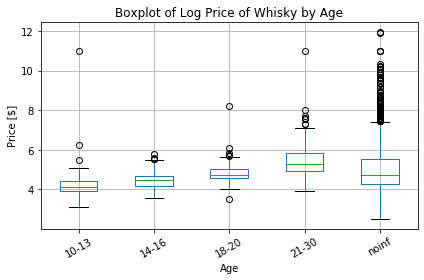

In [116]:
plt.figure(figsize=(10.4,6.8))
dfmodel[['log_price','age']].boxplot(by='age')
plt.suptitle('')
plt.title('Boxplot of Log Price of Whisky by Age')
plt.ylabel('Price [$]')
plt.xlabel('Age')
#plt.ylim(0,800)
plt.xticks(rotation= 30)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/price_age_boxplot.png',dpi=900)
plt.show()

In [117]:
#model with orginial + age + brand
dfmodel["brand"]=names50["brand"]

<Figure size 748.8x489.6 with 0 Axes>

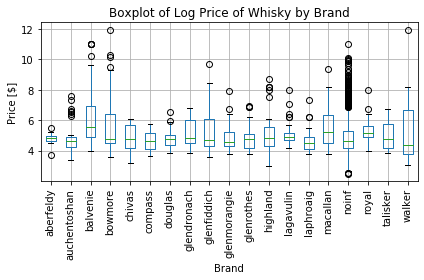

In [118]:
plt.figure(figsize=(10.4,6.8))
dfmodel[['log_price','brand']].boxplot(by='brand')
plt.suptitle('')
plt.title('Boxplot of Log Price of Whisky by Brand')
plt.ylabel('Price [$]')
plt.xlabel('Brand')
#plt.ylim(0,800)
plt.xticks(rotation= 90)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/price_brand_boxplot.png',dpi=900)
plt.show()

In [243]:
#model with original + age
dfage=dfmodel[['review.point','category','percent','d_len','n_len','d_charw','n_charw','age','review2']]
Xage=dfage.values
y=dfmodel[['log_price']]
f_names = list(dfage.columns)
cat_ftr = ['category','age']
num_ftr = ['review.point','percent','d_len','n_len','d_charw','n_charw', 'review2']
dfage.head(2)

review.point               category  percent  d_len  n_len   d_charw  \
0            97  Blended Scotch Whisky     40.0   67.0    5.0  6.537313   
1            97     Single Malt Scotch     40.5   83.0    9.0  5.674699   

    n_charw    age  review2  
0  6.000000  noinf     9409  
1  5.222222  noinf     9409

In [237]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xage,y,i*333, 5, dfage)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.31497892265127025
test score: 0.333177731672306
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.3291708702775929
test score: 0.33685825229353017
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.3310105511593956
test score: 0.3149715108821002
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.31753832181596453
test score: 0.3883172376289571
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.32745771969726917
test score: 0.2958278539345762
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.332756223738882
test score: 0.32801556230346185
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.3251913050892608
test score: 0.34084895258318226
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3599594224939212
test score: 0.1936434534847149
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3520957891439722
test score: 0.3390148481916997
{'kneighborsregressor__n_neighbors': 50}
best C

In [245]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xage,y,i*333, 5, dfage)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'lasso__alpha': 1e-05}
best CV score: 0.31287374847127564
test score: 0.38537359023052264
{'lasso__alpha': 1e-05}
best CV score: 0.3350679054970672
test score: 0.3449975089781394
{'lasso__alpha': 1e-05}
best CV score: 0.34020461849907574
test score: 0.31874470075183636
{'lasso__alpha': 1e-05}
best CV score: 0.336152391072263
test score: 0.3573053798105975
{'lasso__alpha': 1e-05}
best CV score: 0.3426038507331302
test score: 0.31605529520231335
{'lasso__alpha': 1e-05}
best CV score: 0.33834027286542173
test score: 0.3432105400775468
{'lasso__alpha': 1e-05}
best CV score: 0.34667249871814215
test score: 0.3263237884777611
{'lasso__alpha': 1e-05}
best CV score: 0.35855682673144595
test score: 0.2830681447490311
{'lasso__alpha': 1e-05}
best CV score: 0.3501505123474892
test score: 0.30805605910989264
{'lasso__alpha': 1e-05}
best CV score: 0.3557394948460417
test score: 0.2775508600475194
 
BEST 0.38537359023052264
test R2: 0.33 +/- 0.03
mean: 0.32606858674351596
std: 0.03134709037444143


In [246]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xage,y,i*333, 5, dfage)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.35420691680275673
test score: 0.4121243952027792
{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.38012798089498706
test score: 0.4022110749595794
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.3753176380683877
test score: 0.40753789141628405
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.35151989671565836
test score: 0.427444040917736
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.3768589515218239
test score: 0.4014770465142672
{'randomforestregressor__max_depth': 5, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.3782044405574554
test score: 0.30323557729097006
{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples

In [240]:
#model with orginial + age + brand
dfmodel["brand"]=names50["brand"]

In [241]:
#model with original + age
dfab=dfmodel[['review.point','category','percent','d_len','n_len','d_charw','review2','n_charw','age','brand']]
Xab=dfab.values
y=dfmodel[['log_price']]
f_names = list(dfab.columns)
cat_ftr = ['category','age','brand']
num_ftr = ['review.point','percent','d_len','n_len','d_charw','n_charw','review2']
dfab.head(2)

review.point               category  percent  d_len  n_len   d_charw  \
0            97  Blended Scotch Whisky     40.0   67.0    5.0  6.537313   
1            97     Single Malt Scotch     40.5   83.0    9.0  5.674699   

   review2   n_charw    age    brand  
0     9409  6.000000  noinf   walker  
1     9409  5.222222  noinf  bowmore

In [234]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xab,y,i*333, 5, dfab)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3417856703651682
test score: 0.37553673544688126
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.34591254289253
test score: 0.4076207661124307
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3584931625013503
test score: 0.34873353567197285
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3557673082989378
test score: 0.394487343326264
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.35012071000438194
test score: 0.3895027695156391
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.36201757308415805
test score: 0.3066998829614319
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.34990036481977577
test score: 0.33507028175166453
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.37428066607737226
test score: 0.2335564193322146
{'kneighborsregressor__n_neighbors': 5}
best CV score: 0.3558096929176787
test score: 0.36643887403375
{'kneighborsregressor__n_neighbors': 5}
best CV score

In [238]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xab,y,i*333, 5, dfab)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'lasso__alpha': 1e-05}
best CV score: 0.31287374847127564
test score: 0.38537359023052264
{'lasso__alpha': 1e-05}
best CV score: 0.3350679054970672
test score: 0.3449975089781394
{'lasso__alpha': 1e-05}
best CV score: 0.34020461849907574
test score: 0.31874470075183636
{'lasso__alpha': 1e-05}
best CV score: 0.336152391072263
test score: 0.3573053798105975
{'lasso__alpha': 1e-05}
best CV score: 0.3426038507331302
test score: 0.31605529520231335
{'lasso__alpha': 1e-05}
best CV score: 0.33834027286542173
test score: 0.3432105400775468
{'lasso__alpha': 1e-05}
best CV score: 0.34667249871814215
test score: 0.3263237884777611
{'lasso__alpha': 1e-05}
best CV score: 0.35855682673144595
test score: 0.2830681447490311
{'lasso__alpha': 1e-05}
best CV score: 0.3501505123474892
test score: 0.30805605910989264
{'lasso__alpha': 1e-05}
best CV score: 0.3557394948460417
test score: 0.2775508600475194
 
BEST 0.38537359023052264
test R2: 0.33 +/- 0.03
mean: 0.32606858674351596
std: 0.03134709037444143


In [242]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xab,y,i*333, 5, dfab)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.37383017969475213
test score: 0.42892452808722115
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.3908560586234278
test score: 0.43050230067506867
{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.41705937401348664
test score: 0.42288645858484086
{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.38277679452204044
test score: 0.45953242346508627
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.40607453805222476
test score: 0.395704102590298
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.4073657520357188
test score: 0.3322574506669719
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_sa

In [194]:
wordvar = pd.read_csv(dirname(d)+'/Data/ddclean.csv')
wordvar.head()

abandon  abandoned  abc  abdomen  aberdeenshire  aberfeldy  aberlour  \
0        0          0    0        0              0          0         0   
1        0          0    0        0              0          0         0   
2        0          0    0        0              0          0         0   
3        0          0    0        0              0          0         0   
4        0          0    0        0              0          0         0   

   abhainn  abiding  ability  ...  zestyzingy  zigzag  zinfandel  zing  \
0        0        1        0  ...           0       0          0     0   
1        0        0        0  ...           0       0          0     0   
2        0        0        0  ...           0       0          0     0   
3        0        0        0  ...           0       0          0     0   
4        0        0        0  ...           0       0          0     0   

   zinginess  zinging  zingy  zippy  zone  ìle  
0          0        0      0      0     0    0  
1          0        0      0      0     0    0  
2          0        0      0      0     0    0  
3          0        0      0      0     0    0  
4          0        0      0      0     0    0  

[5 rows x 8645 columns]

In [195]:
#only include variables where the freuqncy is at least 200 in model
wordvar.drop([col for col, val in wordvar.sum().iteritems() if val < 200], axis=1, inplace=True)
wordvar.head()

apple  aroma  black  bottle  bottling  bourbon  caramel  cask  chocolate  \
0      1      0      0       0         0        0        2     0          0   
1      0      0      1       0         0        0        0     0          0   
2      0      1      0       1         0        0        0     0          0   
3      0      0      0       1         0        0        0     0          1   
4      1      0      0       0         0        0        1     0          0   

   cinnamon  ...  spicy  subtle  sweet  sweetness  there  toffee  vanilla  \
0         0  ...      0       0      0          1      0       0        1   
1         0  ...      0       0      0          0      0       1        0   
2         0  ...      0       0      0          0      1       0        0   
3         0  ...      0       0      0          0      0       0        0   
4         1  ...      0       0      0          0      0       0        1   

   water  wood  year  
0      0     0     0  
1      0     0     0  
2      0     0     0  
3      0     0     1  
4      0     1     0  

[5 rows x 67 columns]

In [196]:
dfab.head(2)

review.point               category  percent  d_len  n_len   d_charw  \
0            97  Blended Scotch Whisky     40.0   67.0    5.0  6.537313   
1            97     Single Malt Scotch     40.5   83.0    9.0  5.674699   

   review2   n_charw    age    brand  
0     9409  6.000000  noinf   walker  
1     9409  5.222222  noinf  bowmore

In [197]:
dfab_all = pd.concat([dfab,wordvar],axis=1)

In [270]:
#model with original + age + description words
Xab_all=dfab_all.values
y = dfmodel[['log_price']]
f_names = list(dfab_all.columns)
num_ftr = list(dfab_all.columns)
num_ftr.remove('category')
num_ftr.remove('age')
num_ftr.remove('brand')
cat_ftr=['category','age','brand']
dfab_all.head(2)

review.point               category  percent  d_len  n_len   d_charw  \
0            97  Blended Scotch Whisky     40.0   67.0    5.0  6.537313   
1            97     Single Malt Scotch     40.5   83.0    9.0  5.674699   

   review2   n_charw    age    brand  ...  spicy  subtle  sweet  sweetness  \
0     9409  6.000000  noinf   walker  ...      0       0      0          1   
1     9409  5.222222  noinf  bowmore  ...      0       0      0          0   

   there  toffee  vanilla  water  wood  year  
0      0       0        1      0     0     0  
1      0       1        0      0     0     0  

[2 rows x 77 columns]

In [215]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_KNN(Xab_all,y,i*333, 5, dfab_all)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")  
print('BEST', max(test_scores))
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_knn=np.mean(test_scores)
print("mean:",test_knn)
knn_std=np.std(test_scores)
print("std:",knn_std)

{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.16333488606240204
test score: 0.23595312695483472
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1872922973229424
test score: 0.10446049491521081
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.16618182624608774
test score: 0.20537043025277324
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.1871458938747353
test score: 0.20363479978336263
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.19617145392796742
test score: 0.14760009610144165
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.18060061505360367
test score: 0.19191561907045374
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.18405987293926052
test score: 0.18535156278367504
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.19702147143734916
test score: 0.17492842389303975
{'kneighborsregressor__n_neighbors': 50}
best CV score: 0.19419449657412413
test score: 0.15111027461191628
{'kneighborsregressor__n_neigh

In [205]:
print(max(test_scores))

0.23595312695483472


In [211]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_lasso(Xab_all,y,i*333, 5, dfab_all)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_lasso=np.mean(test_scores)
print("mean:",test_lasso)
lasso_std=np.std(test_scores)
print("std:",lasso_std)

{'lasso__alpha': 0.0001}
best CV score: 0.35263210020341396
test score: 0.47278672330418736
{'lasso__alpha': 0.001}
best CV score: 0.3705479945703044
test score: 0.38835832622276256
{'lasso__alpha': 0.001}
best CV score: 0.3805220902605118
test score: 0.40566706441878664
{'lasso__alpha': 0.0001}
best CV score: 0.3734969151706348
test score: 0.3818442520861165
{'lasso__alpha': 0.0001}
best CV score: 0.396996223097512
test score: 0.32914489077784326
{'lasso__alpha': 0.001}
best CV score: 0.3868632515050562
test score: 0.36698952476501523
{'lasso__alpha': 0.0001}
best CV score: 0.3957005550464446
test score: 0.3544962517106388
{'lasso__alpha': 0.0001}
best CV score: 0.4038025555545686
test score: 0.3478520241023584
{'lasso__alpha': 0.0001}
best CV score: 0.39840636465150214
test score: 0.3793659462749307
{'lasso__alpha': 0.001}
best CV score: 0.39704183364068807
test score: 0.33392642393105565
 
BEST 0.47278672330418736
test R2: 0.38 +/- 0.04
mean: 0.3760431427593695
std: 0.03968311287569

In [ ]:
# the 9th iteration is closest to the average R2

In [214]:
test_scores = []
for i in range(10):
    grid, test_score = ML_pipeline_kfold_GridSearchCV_RF(Xab_all,y,i*333, 5, dfab_all)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:', test_score)
    test_scores.append(test_score)
    
print(" ")    
print('BEST', max(test_scores))    
print('test R2:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))
test_rf=np.mean(test_scores)
print("mean:",test_rf)
rf_std=np.std(test_scores)
print("std:",rf_std)

{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samples_split': 5}
best CV score: 0.34609950652261257
test score: 0.4514199476773664
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.4002087163746094
test score: 0.4124654998756687
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.42514215221663054
test score: 0.4511044539424286
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.40639632747732357
test score: 0.4534802197866893
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.3749968386253443
test score: 0.3591232225456079
{'randomforestregressor__max_depth': 20, 'randomforestregressor__min_samples_split': 10}
best CV score: 0.39150856784577687
test score: 0.3474166994667669
{'randomforestregressor__max_depth': 40, 'randomforestregressor__min_samp

In [290]:
def FS_lasso(X,y,random_state,n_folds,DF):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state)
    # splitter for _other
    kf = KFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    
    feature_names = f_names

    cat_ftrs = cat_ftr
    num_ftrs = num_ftr
    
    cat_ftrs_i = [DF.columns.get_loc(x) for x in cat_ftrs]
    num_ftrs_i = [DF.columns.get_loc(x) for x in num_ftrs]

    categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(sparse=False))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    # collect the transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs_i),
            ('cat', categorical_transformer, cat_ftrs_i)]) 
    final_scaler = StandardScaler()
    pipe = make_pipeline(preprocessor,final_scaler, Lasso())
    
    # the parameter(s) we want to tune
    param_grid = {'lasso__alpha': np.logspace(-4,5,num=10)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring=make_scorer(r2_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    feature_names = num_ftrs + \
               list(grid.best_estimator_[0].named_transformers_['cat'][0].get_feature_names(cat_ftrs))
    return grid, np.array(feature_names), X_test, y_test

In [293]:
# grid, feature_names, X_test, y_test = FS_lasso(Xab_all,y,i*333, 5, dfab_all)
# print('test score:',grid.score(X_test,y_test))

# coefs = grid.best_estimator_[-1].coef_
# sorted_indcs = np.argsort(np.abs(coefs))
# plt.rcParams.update({'font.size': 14})
# plt.barh(np.arange(2),coefs[sorted_indcs[-2:]])
# plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
# plt.xlabel('coefficient')
# plt.title('all scaled')
# plt.tight_layout()
# #plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
# plt.show()


In [388]:
best_estimators=[]
for i in range (10):
    grid, feature_names, X_test, y_test = FS_lasso(Xab_all,y,8*333, 5, dfab_all)
    print(grid.best_score_)
    print('test score:',grid.score(X_test,y_test))
    print(grid.best_params_)
    best_estimators.append(grid.best_estimator_)
    
file = open(dirname(d)+'/Results/Best_estimators.save', 'wb')
pickle.dump((best_estimators),file)
file.close()


0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}
0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}


In [379]:
grid, feature_names, X_test, y_test = FS_lasso(Xab_all,y,8*333, 5, dfab_all)
print(grid.best_score_)
print('test score:',grid.score(X_test,y_test))
print(grid.best_params_)

import pickle

file = open(dirname(d)+'/Results/Best_Lasso.save', 'wb')
pickle.dump((grid,X_test,y_test),file)
file.close()

0.3980952179603153
test score: 0.379484958969858
{'lasso__alpha': 0.0001}


In [380]:
import pickle
file = open(dirname(d)+'/Results/Best_Lasso.save', 'rb')
grid, X_test, y_test = pickle.load(file)
file.close()

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid.score(X_test,y_test)
print('test score = ',test_score)
print('test baseline = ',np.sum(y_test == 0)/len(y_test))
# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        df_X_test =  pd.DataFrame(X_test,columns=ftr_names)
        X_test_shuffled = df_X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(df_X_test[ftr_names[i]].values)
        acc_scores.append(grid.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.379484958969858
test baseline =  log_price    0.0
dtype: float64
shuffling review.point
   shuffled test score: -14.503 +/- 0.271
shuffling category
   shuffled test score: 0.304 +/- 0.019
shuffling percent
   shuffled test score: 0.38 +/- 0.002
shuffling d_len
   shuffled test score: 0.369 +/- 0.005
shuffling n_len
   shuffled test score: 0.352 +/- 0.009
shuffling d_charw
   shuffled test score: 0.375 +/- 0.005
shuffling review2
   shuffled test score: -17.136 +/- 0.763
shuffling n_charw
   shuffled test score: 0.335 +/- 0.012
shuffling age
   shuffled test score: 0.255 +/- 0.017
shuffling brand
   shuffled test score: 0.326 +/- 0.005
shuffling apple
   shuffled test score: 0.38 +/- 0.001
shuffling aroma
   shuffled test score: 0.381 +/- 0.0
shuffling black
   shuffled test score: 0.379 +/- 0.001
shuffling bottle
   shuffled test score: 0.322 +/- 0.013
shuffling bottling
   shuffled test score: 0.379 +/- 0.001
shuffling bourbon
   shuffled test score: 0.379 +/- 0.0
shu

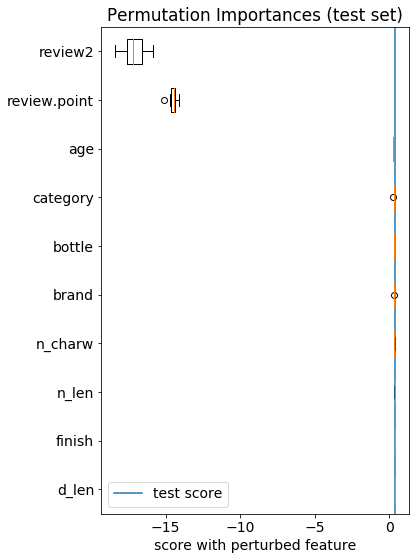

In [391]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
scaled=sorted_indcs[67:77]
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(6,8))
plt.boxplot(scores[scaled].T,labels=ftr_names[scaled],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig(dirname(d)+'/Results/Lasso_feature_imp.png',dpi=300)
plt.show()

In [398]:
dfmodel['age'].value_counts(normalize=True)

noinf    0.600801
21-30    0.141077
10-13    0.119270
14-16    0.084112
18-20    0.054740
Name: age, dtype: float64

In [399]:
dfmodel['brand'].value_counts(normalize=True)

noinf           0.704940
douglas         0.036493
highland        0.032933
bowmore         0.025367
macallan        0.023587
glenrothes      0.020027
compass         0.019137
auchentoshan    0.017356
balvenie        0.016466
glenmorangie    0.015131
laphroaig       0.012906
lagavulin       0.012461
walker          0.012016
glendronach     0.011126
talisker        0.010681
royal           0.009791
glenfiddich     0.008456
aberfeldy       0.005785
chivas          0.005340
Name: brand, dtype: float64

103


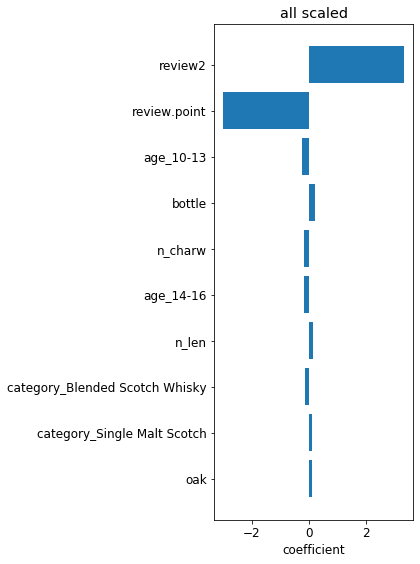

In [390]:
coefs = grid.best_estimator_[-1].coef_
print(len(feature_names))
sorted_indcs = np.argsort(np.abs(coefs))
plt.figure(figsize=(6,8))
plt.rcParams.update({'font.size': 12})
plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig(dirname(d)+'/Results/Lasso_feature_coef.png',dpi=300)
plt.show()


103


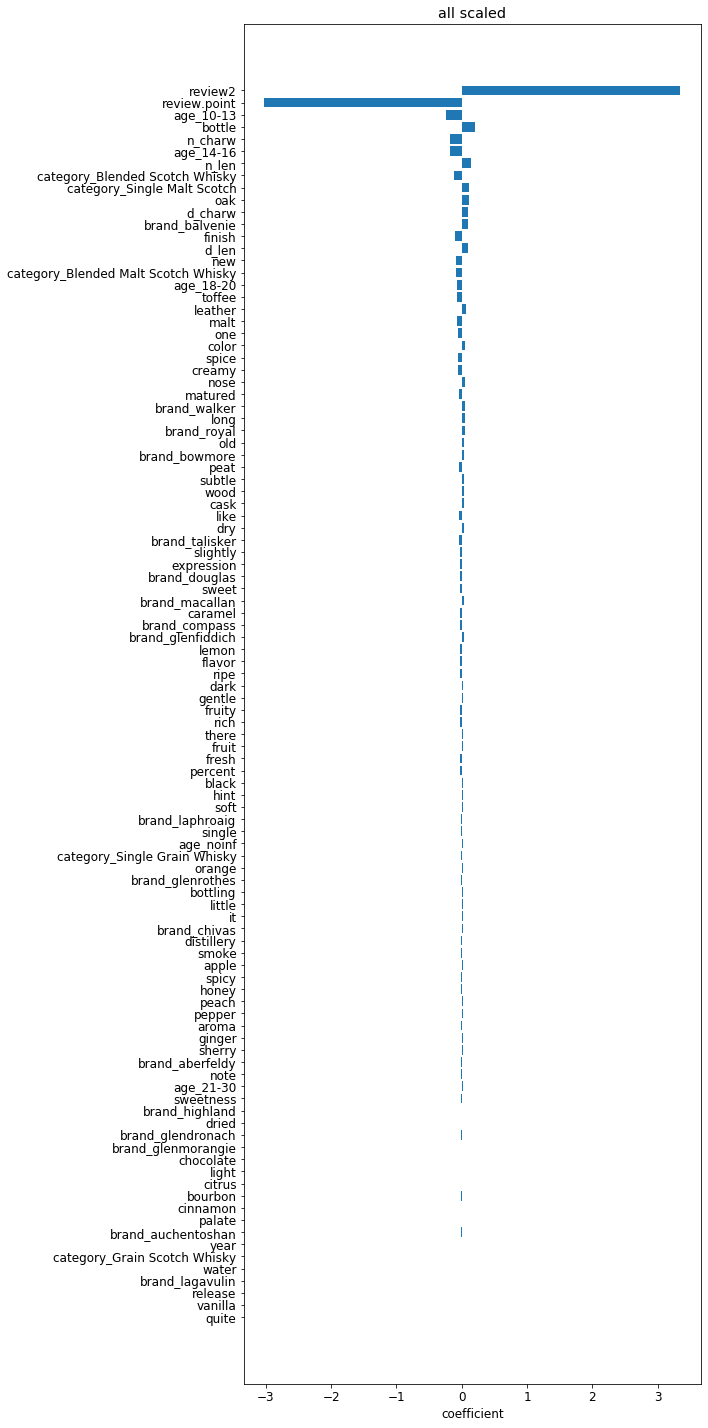

In [392]:
coefs = grid.best_estimator_[-1].coef_
print(len(feature_names))
sorted_indcs = np.argsort(np.abs(coefs))
plt.figure(figsize=(10,20))
plt.rcParams.update({'font.size': 12})
plt.barh(np.arange(102),coefs[sorted_indcs[-102:]])
plt.yticks(np.arange(102),feature_names[sorted_indcs[-102:]])
plt.xlabel('coefficient')
plt.title('all scaled')
plt.tight_layout()
plt.savefig(dirname(d)+'/Results/Full_Lasso_feature_coef.png',dpi=300)
plt.show()
